# W12 lab assignment

In [1]:
import pandas as pd

## Choropleth map

Let's make a choropleth map with the 2016 US Democratic primary statistics. The goal is to replicate a map like [this](https://en.wikipedia.org/wiki/Democratic_Party_presidential_primaries,_2016#/media/File:Democratic_Party_presidential_primaries_results,_2016.svg), but on a county scale: Counties are colored based on whether Hillary Clinton or Bernie Sanders won.

The data can be download the data from Canvas (`democratic_primary_results.csv`). The data is a subset of the [2016 US election dataset from Kaggle](https://www.kaggle.com/benhamner/2016-us-election).

We'll also need an SVG map. We have one on Canvas (`USA_Counties_with_FIPS_and_names.svg`).

First load the data:

In [2]:
results = pd.read_csv('democratic_primary_results.csv')
results.head(2)

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800


The column `fips` is the FIPS code for the county: FIPS stands for Federal Information Processing Standard. Every county has a unique 5-digits FIPS code starting with 0. In our svg file, there is also a `fips` entry, and this is how we are going to use the data to color the svg.

Notice that in the dataframe, the fips code is stored as floats, which means the initial "0" will be dropped. We can fix this by adding the 0s.

In [3]:
def fix_fips(fips):
    fips = str(int(fips))
    if len(fips) == 4:
        fips = '0' + fips
    return fips

In [4]:
results = results.dropna()
results['fips'] = results.apply(lambda row: fix_fips(row['fips']), axis=1)

In [5]:
results.head(2)

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,01001,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,01001,Democrat,Hillary Clinton,2387,0.800


Then Take a look at the SVG map first. If you open the SVG with a text editor, you'll see many `<path>` tags, each one looking like the following:

```<path
     style="font-size:12px;fill:#d0d0d0;fill-rule:nonzero;stroke:#000000;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel"
     d="M 62.678745,259.31235 L 63.560745,258.43135 L 64.220745,257.99135 L 64.439745,258.43135 L 64.000745,258.65135 L 64.439745,258.65135 L 66.643745,257.99135 L 68.626745,255.56635 L 70.388745,256.44835 L 70.388745,256.89035 L 69.727745,257.54935 L 69.727745,258.21235 L 70.388745,257.99135 L 70.829745,256.89035 L 71.269745,256.44835 L 71.930745,257.10835 L 72.150745,257.99135 L 72.811745,258.21235 L 73.030745,257.77135 L 74.131745,257.54935 L 75.894745,257.54935 L 76.113745,257.77135 L 75.673745,258.43135 L 75.673745,258.65135 L 76.996745,258.87235 L 76.774745,259.53235 L 77.656745,259.53235 L 78.757745,258.87235 L 81.180745,258.65135 L 82.722745,259.09235 L 83.386745,259.09235 L 84.044745,259.31235 L 84.267745,259.53235 L 85.148745,259.53235 L 86.249745,259.31235 L 87.572745,259.31235 L 89.114745,259.75435 L 89.554745,259.53235 L 90.436745,258.87235 L 90.655745,258.65135 L 91.096745,258.21235 L 92.639745,258.43135 L 96.163745,259.53235 L 97.264745,263.05835 L 97.925745,265.26135 L 88.893745,267.46435 L 89.334745,269.88635 L 87.572745,270.32735 L 82.945745,271.21135 L 82.722745,271.21135 L 72.371745,272.31135 L 69.947745,272.31135 L 69.947745,271.87035 L 68.186745,271.87035 L 68.186745,271.42935 L 66.423745,271.42935 L 64.661745,271.64935 L 63.338745,271.64935 L 63.338745,271.21135 L 62.678745,271.21135 L 62.678745,271.42935 L 60.696745,271.42935 L 60.255745,271.21135 L 60.034745,271.21135 L 60.034745,271.42935 L 59.154745,271.42935 L 58.932745,270.98935 L 57.831745,270.98935 L 57.831745,271.42935 L 57.389745,271.42935 L 54.304745,271.21135 L 54.304745,272.08935 L 52.762745,272.08935 L 51.441745,271.42935 L 50.780745,270.54735 L 51.220745,269.22735 L 51.441745,267.68335 L 52.983745,267.90535 L 54.967745,267.68335 L 55.626745,267.46435 L 56.948745,265.92135 L 57.611745,263.93935 L 58.932745,261.95735 L 59.814745,261.07435 L 60.474745,261.29735 L 61.356745,260.85535 L 62.678745,259.31235"
     id="02185"
     inkscape:label="North Slope, AK" />```

Each of these is a county. We want to change their `style` tags, namely the `fill` color. We want the color to correspond to the election results in each county. 

In the SVG, there is also an `id` tag for each path, which is the FIPS code. 


 We want to find the paths for each county: there are over 3000 counties, so we'll need a nice way. For this, we can use the `BeautifulSoup` package. This is a package specialized at parsing XMLs.

In [6]:
from bs4 import BeautifulSoup

Read in the svg

In [7]:
svg = open('USA_Counties_with_FIPS_and_names.svg', 'r').read()

Load it with BeautifulSoup

In [8]:
soup = BeautifulSoup(svg)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


BeautifulSoup has a `findAll()` function that finds all given tags.

In [9]:
paths = soup.findAll('path')

In [10]:
len(paths)

3141

In [11]:
paths[0]

<path d="M 62.678745,259.31235 L 63.560745,258.43135 L 64.220745,257.99135 L 64.439745,258.43135 L 64.000745,258.65135 L 64.439745,258.65135 L 66.643745,257.99135 L 68.626745,255.56635 L 70.388745,256.44835 L 70.388745,256.89035 L 69.727745,257.54935 L 69.727745,258.21235 L 70.388745,257.99135 L 70.829745,256.89035 L 71.269745,256.44835 L 71.930745,257.10835 L 72.150745,257.99135 L 72.811745,258.21235 L 73.030745,257.77135 L 74.131745,257.54935 L 75.894745,257.54935 L 76.113745,257.77135 L 75.673745,258.43135 L 75.673745,258.65135 L 76.996745,258.87235 L 76.774745,259.53235 L 77.656745,259.53235 L 78.757745,258.87235 L 81.180745,258.65135 L 82.722745,259.09235 L 83.386745,259.09235 L 84.044745,259.31235 L 84.267745,259.53235 L 85.148745,259.53235 L 86.249745,259.31235 L 87.572745,259.31235 L 89.114745,259.75435 L 89.554745,259.53235 L 90.436745,258.87235 L 90.655745,258.65135 L 91.096745,258.21235 L 92.639745,258.43135 L 96.163745,259.53235 L 97.264745,263.05835 L 97.925745,265.26135 L

The paths are picked out and stored in the variable `paths`. 

Now We should decide on the colors. Many online tools, for example [this](http://htmlcolorcodes.com/) , can be used to look up html color codes. We pick three hexadecimal encodings and put them into a list. (We're not sure if there are ties, so should prepare for that possibility).

In [12]:
colors = ['#ECE23C', '#38B03F', '#8838B0']

In [13]:
# TODO: substitute the above with colors of your choice.

Now we’re going to change the style attribute for each path in the SVG. We’re just interested in fill color, but to make things easier we’re going to replace the entire style instead of parsing to replace only the color. Define the style as the following:

In [14]:
path_style = 'font-size:12px;fill-rule:nonzero;stroke:#000000;stroke-opacity:1;\
stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;\
marker-start:none;stroke-linejoin:bevel;fill:'

Based on the election result, we want to assign each county to a color by simply adding the color code to the end of the string. If Hilary won, we use color code 1; if Sanders won, use color code 2; if it was a tie, use color code 3.

However, look at the cav data again:

In [15]:
results.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,01001,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,01001,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,01003,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,01003,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,01005,Democrat,Bernie Sanders,222,0.078


We notice that it's not straightforward to make the comparison, because, for example, the votes for Bernie Sanders in Autauga and for Hillary Clinton in Autauga are stored in two rows. We need to curate the data a little more.

There are many ways to do this. One way is to "merge" the rows for the same county, resulting in a dataframe like this: (Note I've deleted and renamed some columns for better clarity)

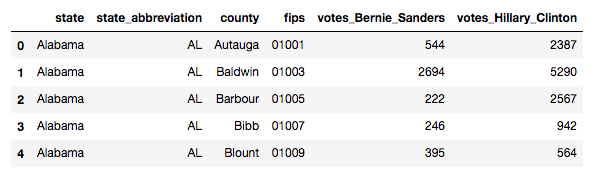

In [16]:
from IPython.display import Image
Image(filename='df_example.png')

To achieve this, we can use the pandas [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function. We can first create two sub-dataframes: One with votes only for Sandas and one only for Clinton. Then we merge these two sub-dataframes, so that the two votes columns will be alongside each other.

Note that this is only one way to achieve our goal. If you have other ways it's fine, and you can modify the rest of the code to make it work.

In [17]:
# todo: Create a new dataframe using pandas merge.

Now we can go back to look at our `path_style`. Use an if condition to choose the color code, and add it to `path_style`. Then put the updated `path_style` back to the path.

In [24]:
for p in paths:
    color_class = ''
    # pick out the FIPS code of this county.
    fips = p['id']
    # compare the votes for Sanders and Hillary in this county.
    vote_b = results[results['fips'].astype(str) == fips]['votes_Bernie_Sanders'].values
    vote_h = results[results['fips'].astype(str) == fips]['votes_Hillary_Clinton'].values

    # if both vote_b and vote_c have values, assign color_class.
    if(vote_b != '' and vote_h != ''):
        # set color class. If Sanders has more votes, 
        # we use the first color code -- index 0 in the list "colors".
        if vote_b > vote_h:
            color_class = 0
        # TODO: decide the rest of the color classes
 
        
    # if we successfully found the fips in the data
    if color_class != '':
        color = colors[color_class]
        p['style'] = path_style + color
 

Remember that we saved the svg in the `soup` object. Now that we have changed the svg to fill with colors, we can just write it out as a new file.

In [25]:
with open ('svg_colored.svg', 'w') as g:
    g.write(soup.prettify())

Open the new svg in your browser. You should be able to see the choropleth map now.